<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучающая-выборка" data-toc-modified-id="Обучающая-выборка-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обучающая выборка</a></span></li><li><span><a href="#Тестовая-выборка" data-toc-modified-id="Тестовая-выборка-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тестовая выборка</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**План по выполнению проекта**

1. Загрузка и подготовка данных.
2. Обучение моделей.
3. Тестирование лучшей модели
4. Выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [48]:
#! pip install lightgbm
#!pip install -qq catboost
#! pip install spacy
#!python -m spacy download en

In [1]:
import numpy as np
import pandas as pd

import nltk

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import re
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import lightgbm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [21]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [22]:
data.info()
print('Количество признаков:', data.shape[1], ', количество наблюдений:', data.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
Количество признаков: 2 , количество наблюдений: 159571


In [23]:
display(data.head(5))

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [24]:
data_pie = data.groupby('toxic').count().reset_index()
data_pie

,toxic,text
0,0,143346
1,1,16225


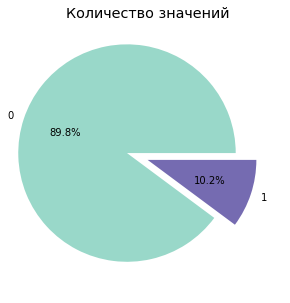

In [25]:
fig, (ax) = plt.subplots(figsize = (5,5))
plt.style.use('ggplot')
ax.pie(data_pie['text'], labels = data_pie['toxic'], autopct='%1.1f%%', explode=[0.2, 0], colors=["#99d8c9", "#756bb1"])

ax.set_title('Количество значений');

- Нам представлен датафрейм текстовых комментариев на английском языке, содержащий 159571 наблюдений и 2 признака.
- Целевой признак - токсичность комментария. Датафрейм содержит 10,2% наблюдения, где признак 1(положительный) и 89,8% наблюдений с нулевым признаком.

Для работы с текстовыми данными необходимо исходный текст лемматизировать и очистить:

In [26]:
nlp = spacy.load('en_core_web_sm') # инициируем модель

def lemma_clear_text(text): # лемматизация и очистка текста
    text = text.lower() #преобразовываем в нижний регистр
    doc = nlp(text) # лемматизируем текст
    lemm_text = " ".join([token.lemma_ for token in doc]) 
    clear_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    
    return " ".join(clear_text.split())

In [27]:
%%time
# полная выборка
data['lemm_text'] = data['text'].apply(lemma_clear_text)
data = data.drop(['text'], axis=1)

CPU times: user 34min 9s, sys: 2.48 s, total: 34min 12s
Wall time: 34min 13s


**Мы подготовим 2 набора обучающих и тестовых выборок:**
1. Полная выборка с CountVectorizer
2. Сбалансированная выборка с TfidfVectorizer

Разделим данные на обучающую и тестовую выборку 9/1:

In [28]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=15456)
print(data_train.shape, data_test.shape)

(143613, 2) (15958, 2)


In [29]:
del data #удаляем лишние данные

Сбалансируем обучающую выборку методом downsampling:

In [30]:
train_zeros = data_train.query('toxic == 0') # нулевые значения toxic
train_ones = data_train.query('toxic != 0') # значения toxic равны 1
print(f' количество значений toxic=0: {train_zeros.shape[0]}')
print(f' количество значений toxic=1: {train_ones.shape[0]}')
print(f'доля {train_ones.shape[0]/train_zeros.shape[0]}')
     

 количество значений toxic=0: 129022
 количество значений toxic=1: 14591
доля 0.11308924059462727


In [31]:
# отбираем случайные данные из train_zeros и объединяем с train_ones
train_downsampled = pd.concat([train_zeros.sample(frac=(train_ones.shape[0]/train_zeros.shape[0]),
                                                  random_state=12345)] + [train_ones])
train_downsampled = shuffle(train_downsampled, random_state=359) # перемешиваем
print(train_downsampled.groupby('toxic').count()) # проверяем

       lemm_text
toxic           
0          14591
1          14591


In [32]:
print(data_train.shape, data_train.head(5)) #проверяем. полная выбрка

        toxic                                          lemm_text
78664       0  remove image again abu badali if you continue ...
48258       0  kenya please do not add nonsense to wikipedia ...
60327       0  I ll have to say that if the purpose of post t...
92666       0  you may be uninterested but wikipedia be you c...
135622      0  wikipedia coi policy chip you probably do not ... (143613, 2)


In [33]:
print( train_downsampled.shape, train_downsampled.head(5))  #проверяем. сокращенная выборка

        toxic                                          lemm_text
100423      1  cesc fabregas I see it be be change that he no...
105537      0  yes thank I guess user be not go to stop the o...
130929      1  oh ouch moreschi and ryanpostlethwaite fucking...
13945       1  I h u I h u u suck ur a nerd w nothing well do...
71181       1                           ooh I be scared fuck you (29182, 2)


In [34]:
print(data_test.shape, data_test.head(5)) #проверяем. тестовая выборка выборка

        toxic                                          lemm_text
139742      0  no personal attack I appologize to the girl fo...
40961       0  frankly I find it ridiculous that hand s notab...
25822       0                  cooking pasteurising freezing etc
45462       0               only a fool turn his back on history
16766       1  any chance I can get this shorten I ll admit I... (15958, 2)


Подготовим features_test и target_test для тестирования

In [37]:
target_test = data_test['toxic']
features_test = data_test.drop(['toxic'], axis=1)
print(target_test.shape, features_test.shape)

(15958,) (15958, 1)


Подготовим features_train и target для обучения (сбалансированная выборка)

In [36]:
target = train_downsampled['toxic']
features_train = train_downsampled.drop(['toxic'], axis=1)
print(target.shape, features_train.shape)

(29182,) (29182, 1)


Расчитаем матрицы tf_idf:

In [38]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

tf_idf_train = count_tf_idf.fit_transform(features_train['lemm_text']) 
tf_idf_test = count_tf_idf.transform(features_test['lemm_text']) 
print("Размер матрицы test:", tf_idf_test.shape)
print("Размер матрицы train:", tf_idf_train.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размер матрицы test: (15958, 50162)
Размер матрицы train: (29182, 50162)


Подготовим features_train и target для обучения на полной выборке

In [35]:
target_data = data_train['toxic']
features_data = data_train.drop(['toxic'], axis=1)
print(target_data.shape, features_data.shape)

(143613,) (143613, 1)


CountVectorizer

In [44]:
vectorizer = CountVectorizer(stop_words=stopwords)
vectorizer.fit(features_data['lemm_text']) 
features_vector = vectorizer.transform(features_data['lemm_text'])
features_vector_test = vectorizer.transform(features_test['lemm_text'])
print(features_vector.shape)
print(features_vector_test.shape)

(143613, 144448)
(15958, 144448)


In [84]:
del train_zeros # удалим ненужные переменные
del train_ones
del data_train
del train_downsampled
del count_tf_idf

У нас подготовлено 2 набора обучающих и тестовых выборок:
1. Полная выборка с CountVectorizer
    - tf_idf_train, target
    - tf_idf_test, target_test
2. Сбалансированная выборка с TfidfVectorizer
    - features_vector, target_data
    - features_vector_test, target_test

**Вывод: Данные готовы для обучения**

## Обучение

Обучение проведем на следующих моделях:

- LogisticRegression()
- CatBoostClassifier()
- MultinomialNB()
- LGBMClassifier()

### Обучающая выборка

In [71]:
def ml(model, features, target, params):
    grcv = GridSearchCV(estimator = model, param_grid = params, cv = 3, scoring = 'f1')
    grcv.fit(features, target)  
    
    f1_result = grcv.best_score_
    params_good = grcv.best_params_
        
    return f1_result, params_good

LogisticRegression

In [72]:
%%time
# Для сбалансированной выборки
params = {'fit_intercept':[True,False], 'C': [1, 7, 9, 15], 'max_iter': [3, 5, 9, 12]}

f1_result, params_good = ml(LogisticRegression(), tf_idf_train, target, params)

print(F'Для сбалансированной выборки f1_result = {f1_result: ,.2f}')
print(params_good)

Для сбалансированной выборки f1_result =  0.90
{'C': 7, 'fit_intercept': False, 'max_iter': 9}
CPU times: user 50.7 s, sys: 1min 40s, total: 2min 31s
Wall time: 2min 31s


In [73]:
%%time
# Для полной выборки
params = {'fit_intercept':[True,False], 'C': [1, 7, 9, 15], 'max_iter': [3, 5, 9, 12]}

f1_result, params_good = ml(LogisticRegression(), features_vector, target_data, params)

print(F'f1_result = {f1_result: ,.2f}')
print(params_good)

f1_result =  0.72
{'C': 7, 'fit_intercept': False, 'max_iter': 12}
CPU times: user 1min 58s, sys: 2min 57s, total: 4min 56s
Wall time: 4min 56s


CatBoostClassifier

In [74]:
%%time
params = {'random_seed': [10, 20],
          'iterations': [200]}
f1_result, params_good = ml(CatBoostClassifier(), tf_idf_train, target, params)

print(F'Для сбалансированной выборки f1_result = {f1_result: ,.2f}')
print(params_good)

Learning rate set to 0.160065
0:	learn: 0.6239937	total: 596ms	remaining: 1m 58s
1:	learn: 0.5899260	total: 1.04s	remaining: 1m 43s
2:	learn: 0.5658152	total: 1.49s	remaining: 1m 37s
3:	learn: 0.5442271	total: 1.94s	remaining: 1m 34s
4:	learn: 0.5284851	total: 2.38s	remaining: 1m 32s
5:	learn: 0.5186164	total: 2.84s	remaining: 1m 31s
6:	learn: 0.5096444	total: 3.27s	remaining: 1m 30s
7:	learn: 0.5011351	total: 3.71s	remaining: 1m 29s
8:	learn: 0.4941272	total: 4.17s	remaining: 1m 28s
9:	learn: 0.4871846	total: 4.61s	remaining: 1m 27s
10:	learn: 0.4782472	total: 5.08s	remaining: 1m 27s
11:	learn: 0.4711347	total: 5.51s	remaining: 1m 26s
12:	learn: 0.4653310	total: 5.94s	remaining: 1m 25s
13:	learn: 0.4611262	total: 6.37s	remaining: 1m 24s
14:	learn: 0.4569359	total: 6.8s	remaining: 1m 23s
15:	learn: 0.4504287	total: 7.22s	remaining: 1m 23s
16:	learn: 0.4455088	total: 7.65s	remaining: 1m 22s
17:	learn: 0.4402429	total: 8.08s	remaining: 1m 21s
18:	learn: 0.4357769	total: 8.51s	remaining: 

In [75]:
%%time
params = {'random_seed': [10, 20, 30],
          'iterations': [200, 500]}
f1_result, params_good = ml(CatBoostClassifier(), features_vector, target_data, params)

print(F'Для полной выборки f1_result = {f1_result: ,.2f}')
print(params_good)

Learning rate set to 0.13643
0:	learn: 0.5625720	total: 810ms	remaining: 6m 44s
1:	learn: 0.4680334	total: 1.69s	remaining: 7m
2:	learn: 0.4004263	total: 2.56s	remaining: 7m 4s
3:	learn: 0.3531861	total: 3.42s	remaining: 7m 3s
4:	learn: 0.3195433	total: 4.29s	remaining: 7m 4s
5:	learn: 0.2954314	total: 5.17s	remaining: 7m 5s
6:	learn: 0.2758300	total: 6.05s	remaining: 7m 5s
7:	learn: 0.2624859	total: 6.91s	remaining: 7m 4s
8:	learn: 0.2526472	total: 7.77s	remaining: 7m 3s
9:	learn: 0.2438150	total: 8.68s	remaining: 7m 5s
10:	learn: 0.2373653	total: 9.56s	remaining: 7m 5s
11:	learn: 0.2319261	total: 10.4s	remaining: 7m 3s
12:	learn: 0.2276198	total: 11.3s	remaining: 7m 3s
13:	learn: 0.2242817	total: 12.2s	remaining: 7m 2s
14:	learn: 0.2204164	total: 13s	remaining: 7m 1s
15:	learn: 0.2177413	total: 13.9s	remaining: 6m 59s
16:	learn: 0.2150589	total: 14.7s	remaining: 6m 59s
17:	learn: 0.2130851	total: 15.6s	remaining: 6m 57s
18:	learn: 0.2107301	total: 16.5s	remaining: 6m 57s
19:	learn: 0

MultinomialNB

In [76]:
%%time
params={'alpha': [0.1, 0.5, 1], 'fit_prior': [True, False]}

f1_result, params_good = ml(MultinomialNB(), tf_idf_train, target, params)

print(F'Для сбалансированной выборки f1_result = {f1_result: ,.2f}')
print(params_good)

Для сбалансированной выборки f1_result =  0.88
{'alpha': 0.5, 'fit_prior': False}
CPU times: user 289 ms, sys: 0 ns, total: 289 ms
Wall time: 295 ms


In [77]:
%%time
params={'alpha': [0.1, 0.5, 1], 'fit_prior': [True, False]}

f1_result, params_good = ml(MultinomialNB(), features_vector, target_data, params)

print(F'Для полной выборки f1_result = {f1_result: ,.2f}')
print(params_good)

Для полной выборки f1_result =  0.69
{'alpha': 0.5, 'fit_prior': True}
CPU times: user 1.24 s, sys: 1.21 ms, total: 1.24 s
Wall time: 1.25 s


LGBMClassifier

In [78]:
%%time
params = {'n_estimators': [120, 150], 'max_depth': [13]}

f1_result, params_good = ml(LGBMClassifier(), tf_idf_train, target, params)

print(F'Для сбалансированной выборки f1_result = {f1_result: ,.2f}')
print(params_good)

Для сбалансированной выборки f1_result =  0.87
{'max_depth': 13, 'n_estimators': 150}
CPU times: user 1min 42s, sys: 0 ns, total: 1min 42s
Wall time: 1min 42s


In [79]:
%%time

X_features = features_vector.astype('float32') #данная модель требует тип данных 'float32', преобразовываем
X_target = target_data.astype('float32')   

params = {'n_estimators': [150], 'max_depth': [13, 20]}

f1_result, params_good = ml(LGBMClassifier(), X_features, X_target, params)

print(F'Для полной выборки f1_result = {f1_result: ,.2f}')
print(params_good)

Для полной выборки f1_result =  0.74
{'max_depth': 20, 'n_estimators': 150}
CPU times: user 5min 27s, sys: 0 ns, total: 5min 27s
Wall time: 5min 27s


Модели показали следующие результаты на обучающей сбалансированной выборки выборке:
- LogisticRegression: f1_result =  0.90 ('C': 7, 'fit_intercept': False, 'max_iter': 9)
- CatBoostClassifier: f1_result =  0.87 ('iterations': 200, 'random_seed': 20)
- MultinomialNB: f1_result =  0.88 ('alpha': 0.5, 'fit_prior': False)
- LGBMClassifier: f1_result =  0.87 ('max_depth': 13, 'n_estimators': 150)

Модели показали следующие результаты на обучающей сбалансированной выборки выборке:

- LogisticRegression: f1_result =  0.72 {'C': 7, 'fit_intercept': False, 'max_iter': 12}
- CatBoostClassifier: f1_result = 0.73 ('iterations': 500, 'random_seed': 30)
- MultinomialNB: f1_result =  0.69 {'alpha': 0.5, 'fit_prior': True}
- LGBMClassifier: f1_result = 0.74 ('max_depth': 20, 'n_estimators': 150)

### Тестовая выборка

In [80]:
def test_ml(model, x_features, x_target, y_features, y_target):
    model.fit(x_features, x_target)
    predict = model.predict(y_features)
    f1_result = f1_score(y_target, predict)
    
    df_ml = pd.DataFrame(target_test)
    df_ml['predict'] = predict
    df_ml['values'] = predict
    df = df_ml.pivot_table(values='values', index='predict', columns='toxic', aggfunc='count')
    sns.heatmap(df, annot=True, center= 0, cmap= 'YlGnBu', fmt ="d");
    
    return f1_result
    print(F'На сбаланстрованной выборке f1_result = {f1_result: ,.2f}')

LogisticRegression

На сбаланстрованной выборке f1_result =  0.67
CPU times: user 2.52 s, sys: 0 ns, total: 2.52 s
Wall time: 2.47 s


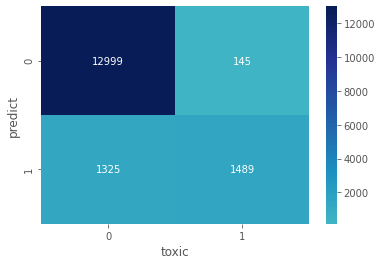

In [81]:
%%time
model = LogisticRegression(C=9, fit_intercept=False, max_iter=9, random_state=12568)
f1_result = test_ml(model, tf_idf_train, target, tf_idf_test, target_test)
print(F'На сбаланстрованной выборке f1_result = {f1_result: ,.2f}')

По графику видно, что на тестовой несбалансированной выборке модель справилась не так хорошо, как на обучающей. Предсказано 13% ложноотрицательных и 9% ложноположительных ответов. Модель присвоила положительную классификацию 2775 наблюдениям (истинноположительных 1634), и в половине случаев (1294) ошиблась. Модель имеет признаки переобучения.

На полной выборке f1_result =  0.73
CPU times: user 3.22 s, sys: 2.22 s, total: 5.44 s
Wall time: 5.44 s


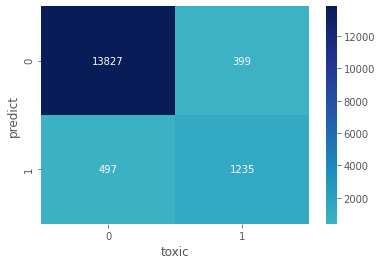

In [82]:
%%time
model = LogisticRegression(C=7, fit_intercept=False, max_iter=12, random_state=12568)
f1_result = test_ml(model, features_vector, target_data, features_vector_test, target_test)
print(F'На полной выборке f1_result = {f1_result: ,.2f}')

Модель LogisticRegression обученная на полной несбалансированной выборке показала такой же хороший результат, как и на обучающей. Предсказано 28% ложноотрицательных и 3,5% ложноположительных ответов. Модель присвоила положительную классификацию 1673 наблюдениям (истинноположительных 1634), и в 1/3 случаев (501) ошиблась.

CatBoostClassifier

 На сбалансированной выборке f1_result =  0.74


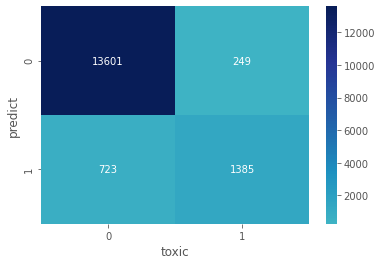

In [83]:
%%time
cat = CatBoostClassifier(random_seed=20, iterations=200, eval_metric="F1")
cat.fit(tf_idf_train, target, verbose=False); #plot=True
predict = cat.predict(tf_idf_test)
f1_result = f1_score(target_test, predict)
df_cb = pd.DataFrame(target_test)
df_cb['predict'] = predict
df_cb['values'] = predict
df = df_cb.pivot_table(values='values', index='predict', columns='toxic', aggfunc='count')
sns.heatmap(df, annot=True, center= 0, cmap= 'YlGnBu', fmt ="d");
print(F' На сбалансированной выборке f1_result = {f1_result: ,.2f}')

Предсказано 17.9% ложноотрицательных и 5% ложноположительных ответов. Модель присвоила положительную классификацию 2037 (истинноположительных 1634) наблюдениям, и ошиблась в 1/3 случаев.

На полной выборке f1_result =  0.75


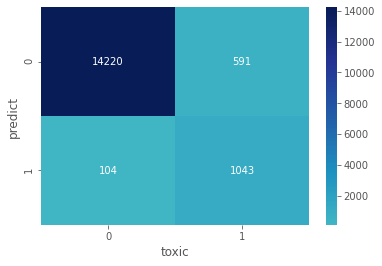

In [84]:
%%time
cat = CatBoostClassifier(random_seed=30, iterations=500, eval_metric="F1")
cat.fit(features_vector, target_data, verbose=False); # plot=True
predict = cat.predict(features_vector_test)
f1_result = f1_score(target_test, predict)
df_cb = pd.DataFrame(target_test)
df_cb['predict'] = predict
df_cb['values'] = predict
df = df_cb.pivot_table(values='values', index='predict', columns='toxic', aggfunc='count')
sns.heatmap(df, annot=True, center= 0, cmap= 'YlGnBu', fmt ="d");
print(F'На полной выборке f1_result = {f1_result: ,.2f}')

Предсказано 36,5% ложноотрицательных и 0,7% ложноположительных ответов. Модель присвоила положительную классификацию 1137 (истинноположительных 1634) наблюдениям, и ошиблась в 9% случаев. Однако, модель имеет признаки переобучени, большой процент потерь токсичных сообщений

MultinomialNB

На сбаланстрованной выборке f1_result =  0.62
CPU times: user 98.7 ms, sys: 44.1 ms, total: 143 ms
Wall time: 140 ms


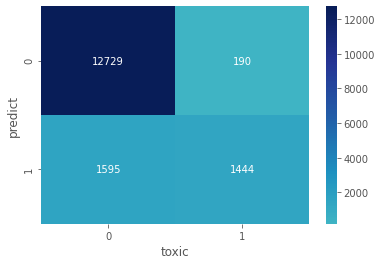

In [85]:
%%time
model = MultinomialNB(alpha=0.5, fit_prior=False)
f1_result = test_ml(model, tf_idf_train, target, tf_idf_test, target_test)
print(F'На сбаланстрованной выборке f1_result = {f1_result: ,.2f}')

Предсказано 11.9% ложноотрицательных и 11.3% ложноположительных ответов. Модель присвоила положительную классификацию 3035 (истинноположительных 1604) наблюдениям, и ошиблась в 53,4% случаев. Модель имеет признаки переобучения, однвко у нее самый маленький процент потерь.

На полной выборке f1_result =  0.68
CPU times: user 121 ms, sys: 62.2 ms, total: 183 ms
Wall time: 162 ms


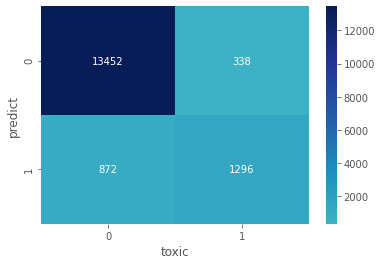

In [86]:
%%time
model = MultinomialNB(alpha=0.5, fit_prior=False)
f1_result = test_ml(model, features_vector, target_data, features_vector_test, target_test)
print(F'На полной выборке f1_result = {f1_result: ,.2f}')

Предсказано 11.9% ложноотрицательных и 11.3% ложноположительных ответов. Модель присвоила положительную классификацию 3035 (истинноположительных 1604) наблюдениям, и ошиблась в 53,4% случаев. Модель имеет признаки переобучения, однвко у нее самый маленький процент потерь.

LGBMClassifier

На сбаланстрованной выборке f1_result =  0.74
CPU times: user 21.9 s, sys: 0 ns, total: 21.9 s
Wall time: 22.1 s


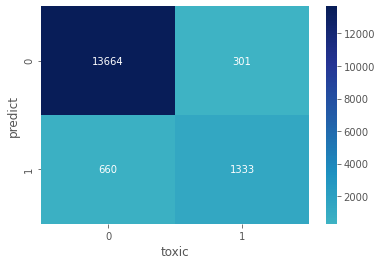

In [87]:
%%time

model = LGBMClassifier(max_depth=13, n_estimators=150, random_state=12568)
f1_result = test_ml(model, tf_idf_train, target, tf_idf_test, target_test)
print(F'На сбаланстрованной выборке f1_result = {f1_result: ,.2f}')

Предсказано 18.8% ложноотрицательных и 5,9% ложноположительных ответов. Модель присвоила положительную классификацию 2007 (истинноположительных 1604) наблюдениям, и ошиблась в 1/3 случаев.

На полной выборке f1_result =  0.76
CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 1min 17s


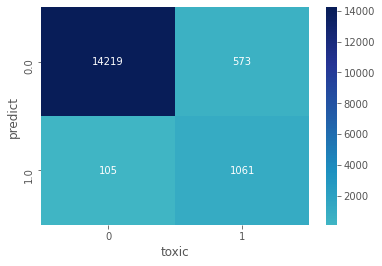

In [88]:
%%time

Y_features = features_vector_test.astype('float32') #данная модель требует тип данных 'float32', преобразовываем
Y_target = target_test.astype('float32')   

model = LGBMClassifier(max_depth=20, n_estimators=150, random_state=12568)
f1_result = test_ml(model, X_features, X_target, Y_features, Y_target)
print(F'На полной выборке f1_result = {f1_result: ,.2f}')

Предсказано 35% ложноотрицательных и 0,7% ложноположительных ответов. Модель присвоила положительную классификацию 1166 (истинноположительных 1634) наблюдениям, и ошиблась в 9% случаев.

DummyClassifier

На сбаланстрованной выборке f1_result =  0.00


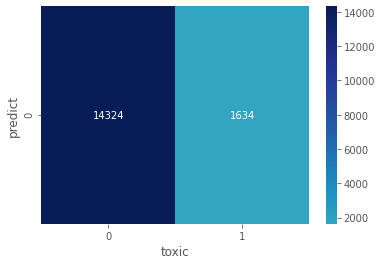

In [89]:
model = DummyClassifier(strategy="most_frequent")
f1_result = test_ml(model, tf_idf_train, target, tf_idf_test, target_test)
print(F'На сбаланстрованной выборке f1_result = {f1_result: ,.2f}')

На полной выборке f1_result =  0.00


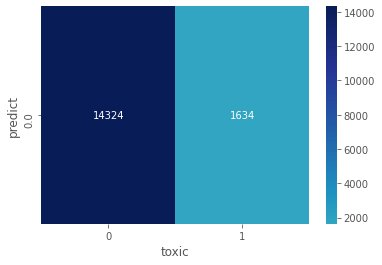

In [90]:
model = DummyClassifier(strategy="most_frequent")
f1_result = test_ml(model, X_features, X_target, Y_features, Y_target)
print(F'На полной выборке f1_result = {f1_result: ,.2f}')

> визуализация данных великая вещь)) Dummy без разбора всем присвоила 1))

Результаты на тестовой сбалансированой выборке:
- LogisticRegression: f1_result =  0.65 (не соответствует техническому заданию)
- CatBoostClassifier: f1_result = 0.72 (не соответствует техническому заданию)
- MultinomialNB: f1_result = 0.61 (не соответствует техническому заданию)
- LGBMClassifier: f1_result = 0.72 (не соответствует техническому заданию)

- *DummyClassifier: f1_result =  0.18 (для сравнения адекватности моделей)*

Результаты на тестовой полной выборке:
- LogisticRegression: f1_result =  0.73 (не соответствует техническому заданию)
- **CatBoostClassifier: f1_result = 0.75 (соответствует техническому заданию)**
- MultinomialNB: f1_result = 0.69 (не соответствует техническому заданию)
- **LGBMClassifier: f1_result = 0.76 (соответствует техническому заданию)**

## Выводы

1. Подготовка:
- Нам представлен датафрейм текстовых комментариев на английском языке, содержащий 159571 наблюдений и 2 признака.
Целевой признак - токсичность комментария. Датафрейм содержит 10,2% наблюдения, где признак 1(положительный) и 89,8% наблюдений с нулевым признаком.
- Для работы с текстовыми данные лемматизированы и очищены.
- Разделили данные на обучающую и тестовую выборку 9/1
- Подготовели 2 набора обучающих и тестовых выборок:
    - Полная выборка с CountVectorizer
    - Сбалансированная выборка с TfidfVectorizer
- Подготовили features и target для обучения и тестирования

2. Обучение проведено на следующих моделях:
- LogisticRegression: f1_result = 0.89 ('fit_intercept': False)
- CatBoostClassifier: f1_result = 0.80 ('depth': 10, 'iterations': 200, 'l2_leaf_reg': 4, 'learning_rate': 0.15)
- MultinomialNB: f1_result = 0.88 ('alpha': 0.5, 'fit_prior': True)
- LGBMClassifier: f1_result = 0.84 ('max_depth': 10, 'n_estimators': 100)

3. В результате тестирования на сбалансированной выборке:
- LogisticRegression: f1_result =  0.65 (не соответствует техническому заданию). По графику видно, что на тестовой несбалансированной выборке модель справилась не так хорошо, как на обучающей. Предсказано 13% ложноотрицательных и 9% ложноположительных ответов. Модель присвоила положительную классификацию 2698 наблюдениям (истинноположительных 1604), и в половине случаев (1304) ошиблась. Модель имеет признаки переобучения.

- CatBoostClassifier: f1_result = 0.72 (не соответствует техническому заданию). Предсказано 17.9% ложноотрицательных и 5% ложноположительных ответов. Модель присвоила положительную классификацию 2037 (истинноположительных 1604) наблюдениям, и ошиблась в 1/3 случаев.

- MultinomialNB: f1_result = 0.61 (не соответствует техническому заданию). Предсказано 11.9% ложноотрицательных и 11.3% ложноположительных ответов. Модель присвоила положительную классификацию 3035 (истинноположительных 1604) наблюдениям, и ошиблась в 53,4% случаев. Модель имеет признаки переобучения

- LGBMClassifier: f1_result = 0.72 (не соответствует техническому заданию). Предсказано 18.8% ложноотрицательных и 5,9% ложноположительных ответов. Модель присвоила положительную классификацию 2007 (истинноположительных 1604) наблюдениям, и ошиблась в 1/3 случаев.

- *DummyClassifier: f1_result =  0.18 (для сравнения адекватности моделей)*

4. В результате тестирования на полной несбалансированной выборке:
- LogisticRegression: f1_result =  0.73 (не соответствует техническому заданию). Модель LogisticRegression обученная на полной несбалансированной выборке показала такой же хороший результат, как и на обучающей. Предсказано 28% ложноотрицательных и 3,5% ложноположительных ответов. Модель присвоила положительную классификацию 1673 наблюдениям (истинноположительных 1634), и в 1/3 случаев (501) ошиблась.

- CatBoostClassifier: f1_result = 0.75 (соответствует техническому заданию). Предсказано 36,5% ложноотрицательных и 0,7% ложноположительных ответов. Модель присвоила положительную классификацию 1137 (истинноположительных 1634) наблюдениям, и ошиблась в 9% случаев. Однако, модель имеет признаки переобучени, большой процент потерь токсичных сообщений

- MultinomialNB: f1_result = 0.68 (не соответствует техническому заданию). Предсказано 11.9% ложноотрицательных и 11.3% ложноположительных ответов. Модель присвоила положительную классификацию 3035 (истинноположительных 1604) наблюдениям, и ошиблась в 53,4% случаев. Модель имеет признаки переобучения

- LGBMClassifier: f1_result = 0.76 (не соответствует техническому заданию). Предсказано 35% ложноотрицательных и 0,7% ложноположительных ответов. Модель присвоила положительную классификацию 1166 (истинноположительных 1634) наблюдениям, и ошиблась в 9% случаев.

**Лучший результат показала модель LGBMClassifier (f1_result = 0.76) на полной несбалансированной выборке**

5. Модели, обученные на полной несбалансированной выорке менее всего были подвержаны переобучению.